# **Data Exploration and Analysis of House Price Offers**

# 1. Introduction

#### **Forewords**

The nominal of house price, especially in Jabodetabek, is always an interesting topic to be discussed because it is continuosly  growing up in unusual trends. In this occasion, we will try to gain insight regarding Jabodetabek house price by utilizing information from the internet. The source of information that we will use is `house listing data from an Indonesian property website`. This website provides service to advertise house listing over all provinces in Indonesia.

#### **Contents**

This chapter will be focused on gaining some valuable insight of variables that is believed to be the important aspect of the house. We will try to apply relevant statistical method to make this analysis as scientifically valid as possible. Informative chart will also be presented to support findings.

After we gain some knowledge about the characteristic that lies underneath the data, in the next chapter of the analysis, we will generalize Jabodetabek house price using a linear model. The parametric form gives an easier interpretation about significancy of its variables in determining the average house price. The purposefulness of this generalization will be demonstrated to solve a simple fictitious problem to maximize profit of housing project, which will be explained in the next chapter.The dataset will then be processed and prepared carefully for our parametric model. Some imputation and transformation will be performed and explained as the final part of 

#### **Objectives**

1. Identifying the dataset's characteristic: number of observations, features, and datatypes
2. Identifying the missing data and ambiguous records and take some actions if needed
3. Analyze the dataset to gain knowledge of Jabodetabek House Price
4. Prepare the dataset for linear model, applying some transformation if deemed necessarry

# 2. Dataset Characteristics

The data contains price of new and used house that offered along with its specification (such as land size, building size, number of floors, etc.). The listing is known to be either placed directly by homeowner (without third party involvement) or placed by some housing agents. Using this data, we can gain insight about *how home-owner in Jabodetabek Area values their house price and how each parameter associates with the offered price, i.e. how significant each of the property's aspect that majority of owners believe will drive their house price worthiness*.

## 2.1. Preparing the Data

Below code provided modules and options that will be utilized over this notebook. The specific analysis environment file (`.yaml`) will be provided in folder `\Environment` associated in this repositories.

In [1]:
# data wrangling, inspecting and utilities modules
import pandas as pd
import numpy as np
import itertools
import re
from modules.data_exploration import DataExploration
import warnings
# statistical analysis modules
from scipy.stats.mstats import mquantiles_cimj, median_cihs
from scipy.stats import bootstrap
# informative chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.graph_objs import Scattermapbox, Layout, Figure
import plotly.express as px
# data transformation modules
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
# modules automating transformation flow
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from joblib import dump

# setting pandas options
pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Load the data 
house_df = pd.read_csv('Scraped_Data/jabodetabek_house_price.csv')

## 2.2. Dataset Features

This chapter explains `features` or `variables` that provided in the dataset.

#### **Features List**

In [2]:
features = house_df.sample(1).T.rename_axis('features', axis='columns')

features

features,658
url,https://www.rumah123.com/properti/bogor/hos113...
price_in_rp,"6,500,000,000.00"
title,Rumah 2 Lantai Baru Unfurnished HGB di Equator...
address,"Sentul City, Bogor"
district,Sentul City
city,Bogor
lat,-6.52
long,106.85
facilities,"Taman, Keamanan 24 jam, Akses Parkir, Taman, ..."
property_type,rumah


The feature names are quite understandable and the values are not ambiguous.

- `Facilities` is unique for each house.
- `Carports` and `Garages` are different entities
- `lat` and `long` represents `estimated geodetical location` of area which that house is located, based on the `address` variables (hence not a specific coordinate of each house). 

#### **Data types of each Features**

Each variables is best explained with specific data type (either in `integer`, `float`, `string` or `categorical`). We will apply data types of each features accordingly as explained as below:

1. Some features that explains *number of instances* (e.g. number of `garages` provided) is best explained as an integer. For convenience, we will cast the datatypes of those features.

2. Some features fall into *categorical* datatypes (e.g. `certificate`) and some categories naturally have order (e.g. `electricity`)

In [3]:
cast_int_cols_indices = [
    (i, format) for i, format in zip(
        [11, 12, 15, 18, 19, 20, 21, 22, 25], itertools.repeat('Int64')
        )
    ]
cast_categorical_cols_indices = [
    (i, format) for i, format in zip(
        [9, 16, 17, 23, 24, 26], itertools.repeat('category')
        )
    ]
for index, format in (
        cast_int_cols_indices 
        + cast_categorical_cols_indices):
    house_df.iloc[:, index] = house_df.iloc[:, index].astype(format, errors='ignore')
    
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   url                   3553 non-null   object  
 1   price_in_rp           3553 non-null   float64 
 2   title                 3553 non-null   object  
 3   address               3553 non-null   object  
 4   district              3553 non-null   object  
 5   city                  3553 non-null   object  
 6   lat                   3553 non-null   float64 
 7   long                  3553 non-null   float64 
 8   facilities            3553 non-null   object  
 9   property_type         3552 non-null   category
 10  ads_id                3549 non-null   object  
 11  bedrooms              3519 non-null   Int64   
 12  bathrooms             3524 non-null   Int64   
 13  land_size_m2          3551 non-null   float64 
 14  building_size_m2      3551 non-null   float64 
 15  carp

Let's inspect each of the categorical column:

In [4]:
category_columns = \
    house_df.select_dtypes(include='category').columns

for column in category_columns:
    categories = list(house_df[column].dtypes.categories)
    print(column, '. Categories: ', categories, '\n')

property_type . Categories:  ['rumah'] 

certificate . Categories:  ['hgb - hak guna bangunan', 'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)', 'shm - sertifikat hak milik'] 

electricity . Categories:  ['10000 mah', '10600 mah', '11000 mah', '12700 mah', '1300 mah', '13200 mah', '13300 mah', '13900 mah', '16500 mah', '17600 mah', '2200 mah', '22000 mah', '23000 mah', '24000 mah', '3300 mah', '33000 mah', '3500 mah', '41500 mah', '4400 mah', '450 mah', '47500 mah', '53000 mah', '5500 mah', '6600 mah', '7600 mah', '7700 mah', '8000 mah', '900 mah', '9500 mah', 'lainnya mah'] 

property_condition . Categories:  ['bagus', 'bagus sekali', 'baru', 'butuh renovasi', 'semi furnished', 'sudah renovasi', 'unfurnished'] 

building_orientation . Categories:  ['barat', 'barat daya', 'barat laut', 'selatan', 'tenggara', 'timur', 'timur laut', 'utara'] 

furnishing . Categories:  ['baru', 'furnished', 'semi furnished', 'unfurnished'] 



Several features have mixed record of categories (for example, `property_condition` has furnishing records, so has `furnishing`) and deemed inconsistent for ordering this categories. Let's inspect those observations:

In [5]:
house_df.loc[house_df.property_condition.isin(['unfurnished', 'semi furnished']), 'property_condition'].value_counts()

unfurnished       25
semi furnished     4
bagus              0
bagus sekali       0
baru               0
butuh renovasi     0
sudah renovasi     0
Name: property_condition, dtype: int64

In [6]:
house_df.loc[house_df.furnishing == 'baru', 'furnishing'].value_counts()

baru              29
furnished          0
semi furnished     0
unfurnished        0
Name: furnishing, dtype: int64

In [7]:
house_df.loc[house_df.furnishing == 'baru', ['url', 'furnishing', 'property_condition']]

,url,furnishing,property_condition
274,https://www.rumah123.com/properti/bekasi/hos11...,baru,semi furnished
275,https://www.rumah123.com/properti/bekasi/hos11...,baru,semi furnished
276,https://www.rumah123.com/properti/bekasi/hos11...,baru,semi furnished
1504,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1505,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1506,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1554,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1555,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1556,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished
1557,https://www.rumah123.com/properti/depok/hos113...,baru,unfurnished


Both condition paired and total observation matches. It maybe in any chance the records are swapped between the columns id `funishing` and `property_condition` (indeed confirmed after further inspection of each url's.)

In [8]:
replace_furnish = house_df.loc[house_df.furnishing == 'baru', 'property_condition']
replace_furnish = pd.Categorical(replace_furnish, categories=['baru', 'furnished', 'semi furnished', 'unfurnished'])
replace_furnish

['semi furnished', 'semi furnished', 'semi furnished', 'unfurnished', 'unfurnished', ..., 'unfurnished', 'unfurnished', 'unfurnished', 'unfurnished', 'unfurnished']
Length: 29
Categories (4, object): ['baru', 'furnished', 'semi furnished', 'unfurnished']

In [9]:
replace_furnish = house_df.loc[house_df.furnishing == 'baru', 'property_condition']
replace_furnish = pd.Categorical(
    replace_furnish, 
    categories=['baru', 'furnished', 'semi furnished', 'unfurnished'])
house_df.loc[house_df.furnishing == 'baru', 'furnishing'] = replace_furnish


house_df.furnishing.value_counts()

unfurnished       2091
semi furnished     837
furnished          238
baru                 0
Name: furnishing, dtype: int64

In [10]:
house_df[house_df.property_condition.isin(['semi furnished', 'unfurnished'])] = \
    house_df[house_df.property_condition.isin(['semi furnished', 'unfurnished'])].assign(
        property_condition='baru'
    ) 

house_df.property_condition.value_counts()

bagus             1437
baru              1357
bagus sekali       261
sudah renovasi     158
butuh renovasi      94
semi furnished       0
unfurnished          0
Name: property_condition, dtype: int64

Lastly, we need to re-adjust categories for each features.

In [11]:
house_df = house_df.assign(
    furnishing=pd.Categorical(
        house_df.furnishing, 
        categories=list(house_df.furnishing.dropna().unique())
        )
    )
house_df = house_df.assign(
    property_condition=pd.Categorical(
        house_df.property_condition, 
        categories=list(house_df.property_condition.dropna().unique())
        )
    )
for column in ['property_condition', 'furnishing']:
    categories = list(house_df[column].dtypes.categories)
    print(column, '. Categories: ', categories, '\n')

property_condition . Categories:  ['bagus', 'bagus sekali', 'baru', 'sudah renovasi', 'butuh renovasi'] 

furnishing . Categories:  ['unfurnished', 'semi furnished', 'furnished'] 



For non-ambiguous categories: `certificate` and `electricity`, will be ordered as follows:

1. Certificate categories order shall be: `1) SHM; 2) HGB; 3) HP; 4) lainnya`.
2. Electricity order shall be based on its energy charge

In [12]:
def sort_elect(string_value):
    num_value = re.findall(r'\d+', string_value)
    if len(num_value) == 0:
        return 0
    else:
        return int(num_value[0])

# ordering of category
certificate_order = [
    'shm - sertifikat hak milik', 'hgb - hak guna bangunan', 
    'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)'
    ]
electricity_order = sorted(
    list(house_df['electricity'].dtypes.categories),
    key=sort_elect
    )
property_condition_order = [
     'baru', 'bagus sekali', 'bagus', 'sudah renovasi',
     'butuh renovasi'
    ]
furnishing_order = [
    'furnished', 'semi furnished', 'unfurnished'
    ]
# apply ordering
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df[column] = \
        pd.Categorical(
            values=house_df[column],
            categories=order,
            ordered=True
            )

#### ***Electricity* Features**

While *ordinal category* of `electricity` features is nice to have as it is pretty distinguishable to analyze (i.e. eliminate value-to-value scaling in an axis thus looks neat in graphical comparison), we also need its numerical format for our regression model.

In [13]:
def electricity_num_format(records):
    try:
        value = float(records.split(' ')[0])
        return value
    except ValueError:
        return np.nan

electricity_num_format_vectd = np.vectorize(electricity_num_format)
house_df = house_df.assign(
    electricity_num=electricity_num_format_vectd(house_df.electricity)
    )

#### ***Facilities* Features**

The `facilities` features is presented in `list` format, meaning that there will be more than one facilities for each house and has a lot of different text between each observations but possibly has similar meaning. Let's unpack the list first. 

In [14]:
house_df = house_df.assign(
    facilities = house_df.facilities.str.split(', ')
    )
for index, facilities in enumerate(house_df.facilities.values):
    for facility in facilities:
        facility_formatted = facility.lower().strip().replace(' ', '_')
        if facility_formatted:
            house_df.loc[house_df.index == index, f'fac_{facility_formatted}'] = 1  

Using lines of code, we will identify similar facilities as a single entity and apply a `one-hot encoding` to provide them as variables.

In [15]:
# merging identical facilities into one
# format: (delete, preserve)
col_pair_duplicated = [
    ('fac_keamanan_24_jam', 'fac_keamanan'),
    ('fac_track_lari', 'fac_jogging_track'),
    ('fac_tempat_laundry', 'fac_tempat_jemuran'),
    ('fac_taman', 'fac_garden'),
    ('fac_carport', 'fac_akses_parkir'),
    ('fac_pemanas_air', 'fac_water_heater'),
    ('fac_kompor', 'fac_kitchen_set'),
    ('fac_2_unit_ac', 'fac_ac'),
    ('fac_carport_1_mobil', 'fac_akses_parkir'),
    ('fac_security_24_jam', 'fac_keamanan'),
    ('fac_pool', 'fac_kolam_renang'),
    ('fac_private_pool', 'fac_kolam_renang'),
    ('fac_kolam_renang_anak', 'fac_kolam_renang'),
    ('fac_kitchen_set_(opsional)', 'fac_kitchen_set'),
    ('fac_security24_jam', 'fac_keamanan'),
    ('fac_taman_luas', 'fac_garden'),
    ('fac_musholla_exclusive', 'fac_masjid'),
    ('fac_toren_500_liter', 'fac_plumbing_system'),
    ('fac_torn_650ltr', 'fac_plumbing_system'),
    ('fac_one_gate_sistem', 'fac_one_gate_system'),
    ('fac_torn_air', 'fac_plumbing_system'),
    ('fac_jetpump', 'fac_plumbing_system'),
    ('fac_cctv_area', 'fac_cctv'),
    ('fac_mushola', 'fac_masjid'),
    ('fac_security_24h', 'fac_keamanan'),
    ('fac_taman_minimalis', 'fac_garden'),
    ('fac_swimming_pool', 'fac_kolam_renang'),
    ('fac_full_kitchen_set', 'fac_kitchen_set'),
    ('fac_ac_2_unit', 'fac_ac'),
    ('fac_ac_3_unit', 'fac_ac'),
    ('fac_free_kitchen_set', 'fac_kitchen_set'),
    ('fac_onegate', 'fac_one_gate_system'),
    ('fac_security_24jam', 'fac_keamanan'),
    ('fac_1_unit_ac', 'fac_ac'),
    ('fac_securty_24_jam', 'fac_keamanan'),
    ('fac_carport_2_mobil', 'fac_akses_parkir'),
    ('fac_smart_lock_door', 'fac_smart_home'),
    ('fac_torrent', 'fac_plumbing_system'),
    ('fac_servis_area', 'fac_service_area'),
    ('fac_smarthome', 'fac_smart_home'),
    ('fac_dapur_bersih_dan_kotor', 'fac_wastafel'),
    ('fac_pompa_air_wasser_dan_booster', 'fac_plumbing_system'),
    ('fac_kompor_exhaust', 'fac_kitchen_set')
    ]
fac_to_drop = [
    'fac_posisi_hoek', 'fac_void', 'fac_living_room',
    'fac_lemari_kayu', 'fac_pagar'
    ]
for delete, preserve in col_pair_duplicated:
    house_df.loc[house_df[delete] == 1, preserve] = 1
    house_df.drop(
     delete, axis=1, inplace=True   
    )
house_df.drop(
    fac_to_drop, axis=1, inplace=True
    )
# manually apply one-hot encoding
fac_columns = house_df.columns[pd.Series(house_df.columns).str.contains('fac_.*', regex=True)]
n_ = len(fac_columns)
fillna_fac = dict([(i) for i in zip(
    fac_columns, 
    list(itertools.repeat(0, n_)))
    ])
house_df.fillna(fillna_fac, inplace=True)
house_df.loc[:, list(fac_columns)] = house_df.loc[:, list(fac_columns)].astype('Int64', errors='ignore')

house_df.sample(3).T

,1746,2990,2227
url,https://www.rumah123.com/properti/depok/hos106...,https://www.rumah123.com/properti/tangerang/ho...,https://www.rumah123.com/properti/jakarta-bara...
price_in_rp,"1,800,000,000.00","6,900,000,000.00","3,200,000,000.00"
title,Rumah Strategis di Panoramic Garden Dekat Tapo...,RUMAH MEWAH BANGETT MODERN CLASSIC MATERIAL BE...,ANDRE TJHIA Meruya Tanah 10x25 Lokasi Bagus Sa...
address,"Sukmajaya, Depok","BSD The Icon, Tangerang","Meruya, Jakarta Barat"
district,Sukmajaya,BSD The Icon,Meruya
city,Depok,Tangerang,Jakarta Barat
lat,-6.40,-6.31,-6.21
long,106.84,106.65,106.73
facilities,"[Keamanan, Taman]","[Masjid, Jogging Track, Taman, Keamanan, CC...","[Taman, Ac, AC, Keamanan, Track Lari, Joggin..."
property_type,rumah,rumah,rumah


## 2.3. Duplicated Observations

There is a chance that house's owner publish multiple ads for their house, which will be recorded as different `url` although other records are the same. So we will drop if any duplicated observations exist.

In [16]:
duplicates_nos = len(house_df[house_df.drop(['facilities', 'url'], axis=1).duplicated()])
print(f'Duplicated observations: {duplicates_nos}')

Duplicated observations: 88


In [17]:
house_df.drop(
    house_df[house_df.drop(['facilities', 'url'], axis=1).duplicated()].index, 
    inplace=True
    )
duplicates_nos = len(house_df[house_df.drop('facilities', axis=1).iloc[:, 1:-1].duplicated()])
print(f'Duplicated observations: {duplicates_nos}')

Duplicated observations: 0


## 2.4. Features with Suspicious Records

The most simple way to detect anomaly in the records is by taking a quick glance in the dataset summary.

In [18]:
house_df.iloc[:, 0:15].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,465.00","4,182,611,544.01","13,884,600,751.69","42,000,000.00","1,500,000,000.00","580,000,000,000.00"
lat,"3,465.00",-6.33,0.13,-6.89,-6.30,-6.10
long,"3,465.00",106.79,0.17,106.40,106.80,109.77
bedrooms,"3,432.00",3.33,2.70,1.00,3.00,99.00
bathrooms,"3,437.00",2.63,2.73,1.00,2.00,99.00
land_size_m2,"3,463.00",205.16,405.84,12.00,108.00,"8,000.00"
building_size_m2,"3,463.00",186.14,249.04,1.00,110.00,"6,000.00"


It is also useful to identify patterns and range of each variables using automatically-generated histogram, as below.

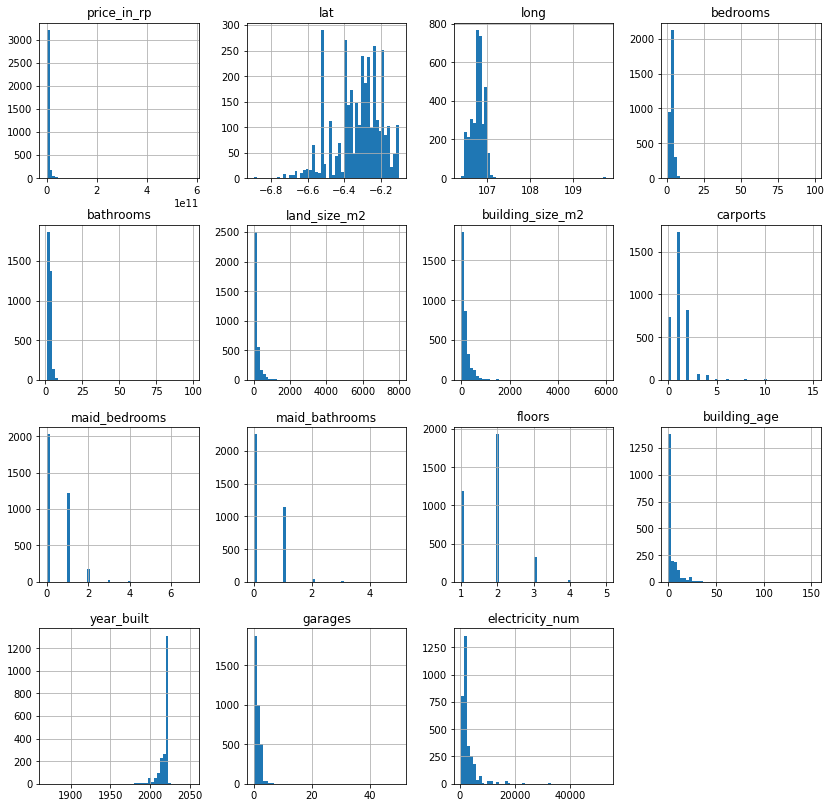

In [19]:
house_df.iloc[:, 0:28].hist(bins=50, figsize=(14, 14))
plt.show()

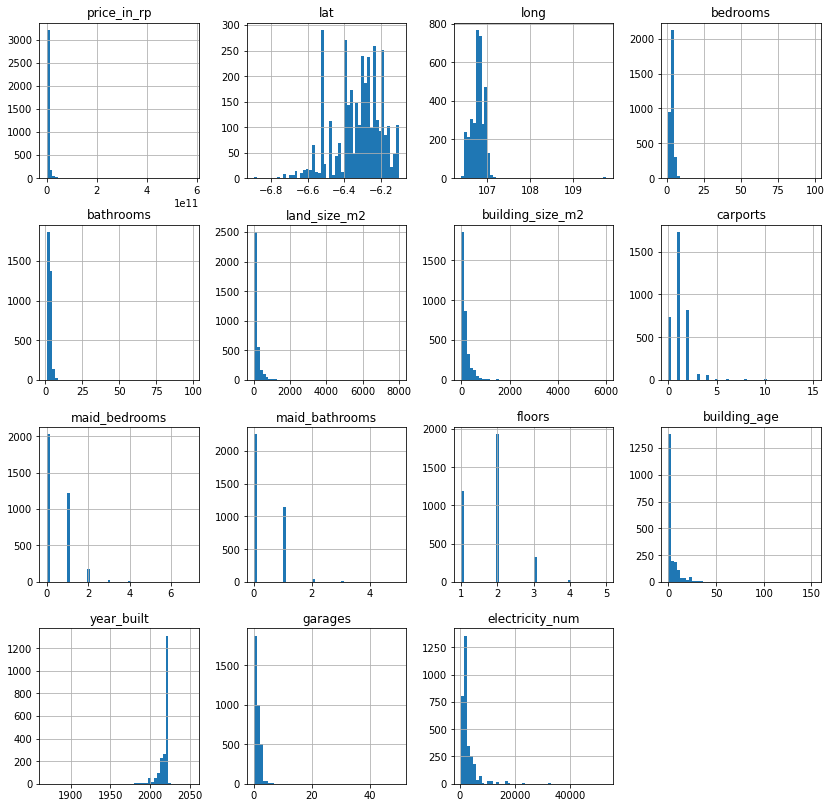

In [20]:
house_df.iloc[:, 0:28].hist(bins=50, figsize=(14, 14))
plt.show()

We can see that the data is right-skewed heavily.

For `facilities` feature, we can also inspect the histogram to take a quick glance of their proportion from overall dataset. 

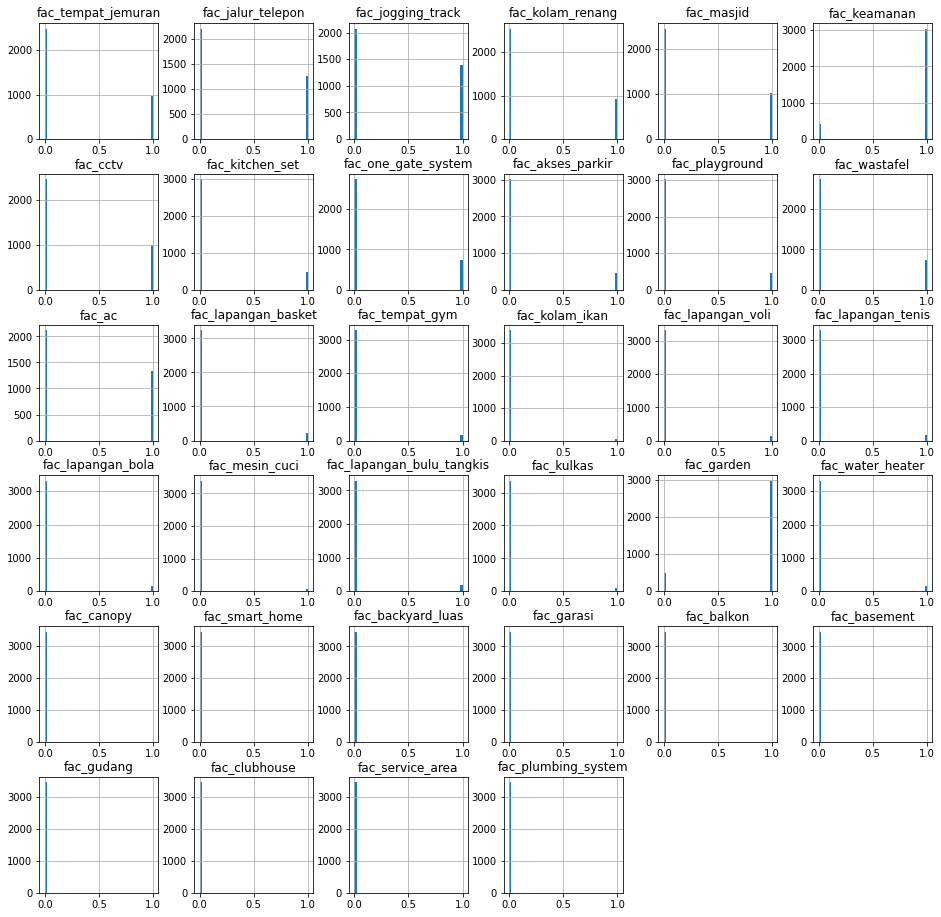

In [21]:
house_df.iloc[:, 28:].hist(bins=50, figsize=(16, 16))
plt.xticks([0, 1])
plt.show()

Majority of the facilities has a very low proportion of existance. For example, majority of observations don't have `fac_plumbing_system` in their record. Those kind of variables possibly will be proven insignificant as a feature to generalize the dataset.

#### **Price Records**

In [22]:
{"tags": ["hide-input"]}

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,465.00","4,182,611,544.01","13,884,600,751.69","42,000,000.00","1,500,000,000.00","580,000,000,000.00"


Surely, standard deviation of `price_in_rp` is inflated by a nonproportionally large maximum price records. Currently largest value is Rp. 580 Billion, which is abnormally high for house price. 

After inspecting, turns out that in the description, it explains that the price should be Rp. 5.8 Billion.

In [23]:
house_df.loc[house_df.price_in_rp == 580000000000, 'price_in_rp'] = 5800000000

The minimum price is also suspicious for typical house price in Jabodetabek (only Rp. 42 million). 

In [24]:
minimum_price = house_df.loc[
        house_df.price_in_rp == 42000000, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ]
minimum_price

,url,price_in_rp,bedrooms,land_size_m2,building_size_m2,floors
159,https://www.rumah123.com/properti/bekasi/hos11...,"42,000,000.00",2,60.00,40.00,1
340,https://www.rumah123.com/properti/bekasi/hos11...,"42,000,000.00",2,60.00,40.00,1


After further inspection, turns out those records are house listing offer for *Credit Transfer*, and the price records are the *Credit Transfer Fee*. We should remove those records and other *Credit Transfer* offers since those sample may disturb our price distribution and irrelevant for our subject of analysis.

In [25]:
house_df = house_df.assign(
    title=house_df.title.str.lower().replace(r'\n', ' ', regex=True).replace('*', '')
    )
title_tag_to_drop = [
    'overkredit', 'over kredit', 'oper kredit', 'operkredit', 
    'takeover', 'take over', 'take oper','oper', 'dioper', 'diover']
price_records_to_drop = [
    42000000, 70000000, 75000000, 85000000, 100000000, 130000000,
    135000000
    ]
url_to_drop = [
    'https://www.rumah123.com/properti/bogor/hos11086291/#qid~a3b85dc6-9dd7-4fa9-9eac-113f4eba7868',
    'https://www.rumah123.com/properti/tangerang/hos11359461/#qid~0d9492e8-7326-465d-85ee-e54559fedc26',
    'https://www.rumah123.com/properti/bogor/hos11351345/#qid~9ab0b10c-8ceb-4c9a-9e7a-479f91a141d1'
    ]
for tag in title_tag_to_drop:
    house_df.drop(
        house_df[house_df.title.str.contains(f'^{tag}\s')].index,
        inplace=True
    )
    house_df.drop(
        house_df[house_df.title.str.contains(f'\s{tag}\s')].index,
        inplace=True
    )
    house_df.drop(
        house_df[house_df.title.str.contains(f'\s{tag}$')].index,
        inplace=True
    )
for price in price_records_to_drop:
    house_df.drop(
        house_df[house_df.price_in_rp == price].index,
        inplace=True)
for url in url_to_drop:
    house_df.drop(
        house_df[house_df.url == url].index,
        inplace=True)
house_df[house_df.url == 'https://www.rumah123.com/properti/bekasi/hos11222131/#qid~aeb345f5-d0dd-46bf-8173-9872e4274ee2']\
    .price_in_rp == 1250000000

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,446.00","4,038,244,631.46","9,873,694,516.03","125,000,000.00","1,500,000,000.00","250,000,000,000.00"


Above codes is our best approach to fix some minimum values.

In the next chapter, we will analyze the effect of the suspicious prices using the more proven statistical approaches such as `outliers detection`, `high leverage observation`, and `cook distance`.

#### **Bedrooms & Bathrooms Records**

In [26]:
{"tags": ["hide-input"]}

house_df[['bedrooms', 'bathrooms']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
bedrooms,"3,414.00",3.34,2.71,1.00,3.00,99.00
bathrooms,"3,418.00",2.63,2.73,1.00,2.00,99.00


In [27]:
pd.DataFrame({
    'count':house_df[['bedrooms']].value_counts().sort_index()
}).T

bedrooms,1,2,3,4,5,6,7,8,9,10,11,12,13,16,20,21,36,37,50,54,57,99
count,18,919,1342,780,212,92,14,10,2,5,2,5,2,2,2,1,1,1,1,1,1,1


In [28]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['bathrooms']].value_counts().sort_index()
}).T

bathrooms,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,20,21,36,50,54,57,99
count,747,1099,943,434,109,33,20,10,3,3,2,3,1,2,1,2,1,1,1,1,1,1


Simple logic, house with a large amount of bedrooms/bathrooms tends to associated with large building size. House with >= 20 bedrooms may raise suspicion (especially 99!).

In [29]:
large_bedrooms_inst = house_df.loc[
        house_df.bedrooms >= 20, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ].sort_values('bedrooms')

large_bedrooms_inst

,url,price_in_rp,bedrooms,land_size_m2,building_size_m2,floors
2283,https://www.rumah123.com/properti/jakarta-sela...,"26,000,000,000.00",20,915.00,600.00,2
2545,https://www.rumah123.com/properti/jakarta-sela...,"27,000,000,000.00",20,"1,195.00",950.00,2
2282,https://www.rumah123.com/properti/jakarta-sela...,"26,000,000,000.00",21,900.00,700.00,2
346,https://www.rumah123.com/properti/bekasi/hos11...,"9,000,000,000.00",36,939.00,500.00,1
1333,https://www.rumah123.com/properti/bogor/hos109...,"2,700,000,000.00",37,500.00,350.00,1
2483,https://www.rumah123.com/properti/jakarta-sela...,"30,000,000,000.00",50,517.00,"2,417.00",5
2687,https://www.rumah123.com/properti/jakarta-sela...,"28,000,000,000.00",54,890.00,"1,800.00",5
2634,https://www.rumah123.com/properti/jakarta-sela...,"11,800,000,000.00",57,491.00,"1,500.00",4
2888,https://www.rumah123.com/properti/tangerang/ho...,"55,000,000,000.00",99,"1,150.00","6,000.00",4


Turns out that houses with large number of bedrooms is either `boarding house `(*kost*) or `guest house`. Let's just keep those records.

#### **Land and Building Size**

In [30]:
{"tags": ["hide-input"]}

house_df[['land_size_m2', 'building_size_m2']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
land_size_m2,"3,444.00",205.92,406.82,12.00,108.00,"8,000.00"
building_size_m2,"3,444.00",186.91,249.50,1.00,112.50,"6,000.00"


There is a suspicious observation with `building size = 1 m2` and we will drop this observations.

In [31]:
house_df.drop(
    house_df[house_df.building_size_m2 == 1].index, inplace=True)

#### **Garages**

In [32]:
{"tags": ["hide-input"]}

house_df[['garages']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
garages,"3,445.00",0.71,1.32,0.00,0.00,50.00


In [33]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['garages']].value_counts().sort_index()
}).T

garages,0,1,2,3,4,5,6,10,12,20,50
count,1864,991,497,31,40,6,10,3,1,1,1


Let's inspect house with 50 garages:

In [34]:
large_garages_inst = house_df.loc[
        house_df.garages >= 50, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors', 'garages']
    ]

large_garages_inst

,url,price_in_rp,bedrooms,land_size_m2,building_size_m2,floors,garages
2888,https://www.rumah123.com/properti/tangerang/ho...,"55,000,000,000.00",99,"1,150.00","6,000.00",4,50


Turns out that houses with large number of garages is the house with 50 bedrooms i.e. the `boarding house `(*kost*), which explains the provided capacities for vehicle.

## 2.5. Zeroes and Missing Records

#### **Zeroes Records**

Records containing zero values are rather not ambiguous. For example, if `maid_bedrooms = 0`, it explains that this house doesn't provide bedroom for maid. Similar reasoning can safely be applied for other features, except for: `price in rp`, `lat`, `long`, `bedrooms`, `bathrooms`, `lands & building size`, and `floors`.

Let's explore proportion of zeroes records for each feature contains numerical data:

In [35]:
def show_nans_or_zeroes(data, label: str, filter=None):
    features = list(filter) or list(data.columns)
    total_records = data.shape[0]
    if label == 'nans':
        label_data = (data[features].isna())
    elif label == 'zeroes':
        label_data = (data[features] == 0)
    else:
        raise ValueError('Wrong argument for "label"')
    label_count = label_data.sum()
    label_percent = label_data.mean() * 100
    data_types = data[features].dtypes
    return(
        pd.DataFrame({f'{label} Count'.title(): label_count, 
            f'{label} Percentage (%)'.title(): label_percent,
            'Data Types': data_types
        })
    )
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
show_nans_or_zeroes(house_df, 'zeroes', numerical_features)

,Zeroes Count,Zeroes Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,Int64
bathrooms,0,0.00,Int64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,733,21.28,Int64
maid_bedrooms,2010,58.35,Int64
maid_bathrooms,2239,64.99,Int64


Fortunately, primary characteristics of the house don't contain zeroes. 

There are some facilities that has a large portion of zeroes record. Analysis that presented in the next chapter will prove how significant those facilities

#### **Missing Records**

Let's fist explore missing records for numerical features.

In [36]:
show_nans_or_zeroes(house_df, 'nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,32,0.93,Int64
bathrooms,28,0.81,Int64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,Int64
maid_bedrooms,0,0.00,Int64
maid_bathrooms,0,0.00,Int64


Almost half of the dataset contains observations with missing `building_age`, so **deducting analysis from this features is not appropriate hence will not be performed**.

For other features with missing records, it is safe to ignore those observations for now since they only cover less than 1% of total rows in the dataset. But for developing `regression model`, particular features will be imputed accordingly.

For categorical and string features:

In [37]:
non_numeric_features = house_df.select_dtypes(include=['object', 'category']).columns
show_nans_or_zeroes(house_df, 'nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
property_type,1,0.03,category
ads_id,4,0.12,object
certificate,140,4.06,category
electricity,0,0.00,category


Other than `building_orientation`, those features suffers from zero to slightly missing records.

# 3. Data Exploration

## 3.1. Median Statistics of House Price

Due to the presence of right-skewness in our dataset, it is best to use `median` to represent typical house price as the center of price distribution, since the `mean` statistic will be inflated by expensive house.

Recall the `price_in_rp` distribution presented in previous chart is clearly not informative because the distribution is heavily skewed. We will apply `log-scale` to the chart axis to enhance the information presented.

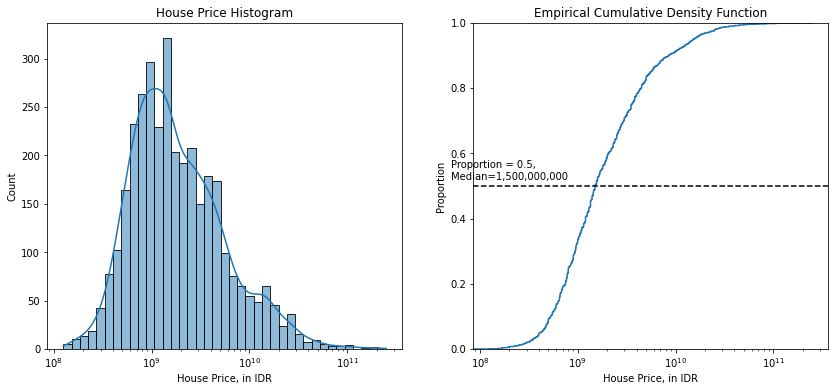

In [38]:
median = house_df['price_in_rp'].median()
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(
    data=house_df, x='price_in_rp', kde=True, 
    log_scale=True, ax=ax[0]
    )
sns.ecdfplot(
    data=house_df, x='price_in_rp', log_scale=True, ax=ax[1]
)
ax[0].set_title('House Price Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5e7, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')
plt.show()

Note that the right-skewness also clearly visible even after `log-scaling` the axis. 

The `median` price of overall dataset, which represents `Jabodetabek House Price`, is located at `Rp. 1,500,000,000 (1.5 billions rupiahs)`.

Now let's distinguish median prices between each Jabodetabek area.

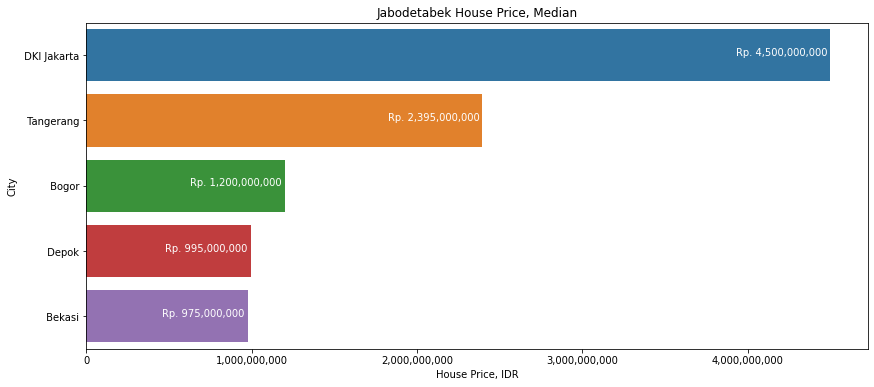

In [39]:
house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
median = house_df_simple[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
# plot_order = list(median.sort_values('price_in_rp', ascending=False).city)
plt.figure(figsize=(14, 6))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('Jabodetabek House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()

DKI Jakarta has the largest median price among others. The median house price between `Bogor, Depok, and Bekasi` is generally typical.

Identifying median statistics alone is not sufficient enough to figure out typical range of house price, thus we also need to inspect the house price distribution.

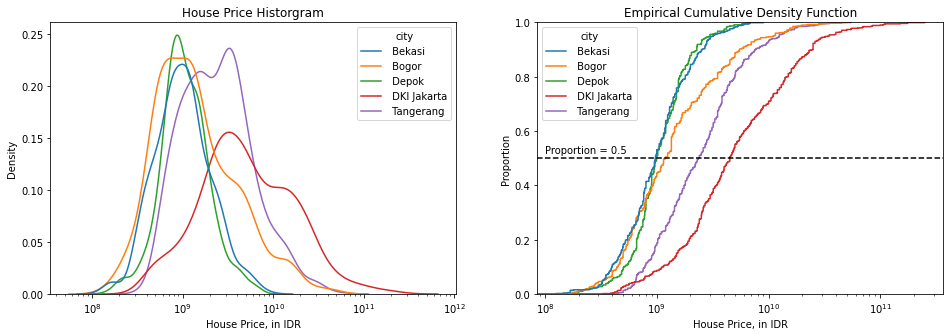

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_simple, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_simple, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
    )
ax[0].set_title('House Price Historgram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=1e8, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')
plt.show()

Turns out that the distribution between `Bogor, Depok, and Bekasi` is also typical. However, `Bogor` is more right-skewed among them, possibly suggesting that there are **some areas in** `Bogor` **that has a significantly higher price** than their typical price range. 

The `lat-long` data can be utilized to show distribution of Jabodetabek house price on an interesting cartographical chart, as below:

In [55]:
median_df = \
    house_df\
        .groupby('district')\
        .agg(median_price=('price_in_rp', np.median), 
             unit_count=('price_in_rp', np.count_nonzero),
             median_size=('building_size_m2', np.median)
            )\
        .reset_index()\
        .merge(house_df[['district','city', 'lat', 'long']].drop_duplicates(subset=['district']), on='district')\
        .sort_values('city')
hover_data = {
    'district': True,
    'city': True,
    'lat': False,
    'long': False,
    'median_price': ':,.0f',
    'median_size': ':,.0f',
    'unit_count': True,
    }    
fig = px.scatter_mapbox(
    median_df, lat='lat', lon='long', 
    color='city', size=(median_df.median_price / 10e3),
    hover_data=hover_data, hover_name='district', 
    )
fig.update_layout(
    title='Jabodetabek House Price Map',
    mapbox_style="carto-darkmatter",            
    autosize=True,
    hovermode='closest', 
    )
fig.show(renderer='iframe')


The `median` statistics is applied for each `district in Jabodetabek` which determine the bubbles size. The unit count is also associated in the bubbles which become visible by hovering the cursor over the buble. 

- DKI Jakarta has most larger bubbles among other city.

- Note that some districts in `Bogor` has larger bubbles than most of `Depok, Bekasi` bubbles, reinforcing our previous insight.

- For `Jakarta Utara` area, most of the observations unfortunately only presented for areas, which most *'Jakartans'* known, as some of the *most elite housing area* that DKI Jakarta currently has. This will possibly create a biased representation of `Jakarta Utara` House price. We found a limitation in our dataset, so I will acknowledge this finding on every important aspect of our analysis.     

#### **DKI Jakarta House Price**

Now let's distinguish median price among DKI Jakarta.

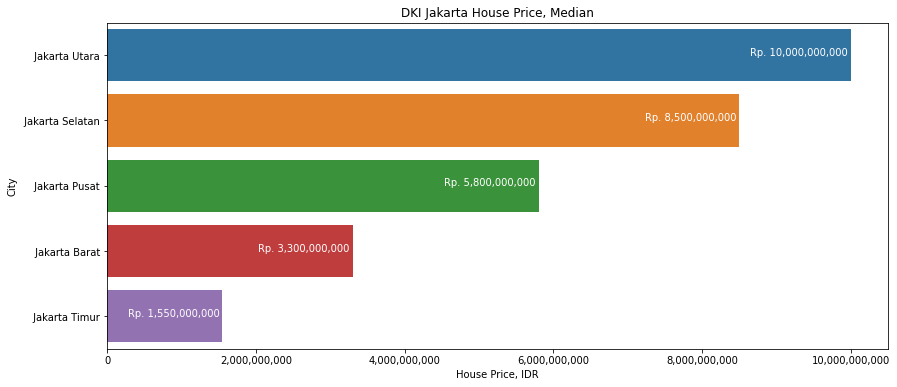

In [45]:
house_df_jakarta = house_df[house_df.city.str.contains('Jakarta')]
median = house_df_jakarta[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('DKI Jakarta House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()

`Jakarta Utara` has the largest median price. `Jakarta Timur` has the lowest median and rather close to `Bogor, Depok and Bekasi`.

Recall that Jakarta Utara suggest imbalanced proportion of the records, and may also be presents to other city in DKI Jakarta. Let's inspect their records' proportion.

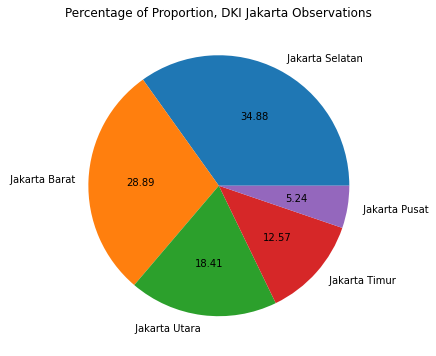

In [46]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(figsize=(12, 6))
house_df_jakarta.city.value_counts().plot.pie(autopct="%.2f", ax=ax)
ax.set_ylabel('')
ax.set_title('Percentage of Proportion, DKI Jakarta Observations')
plt.show()

`Jakarta Utara` is indeed has a small proportion. However, `Jakarta Pusat` and `Jakarta Timur` has somewhat much smaller portion of dataset. Let's further inspect their distribution:

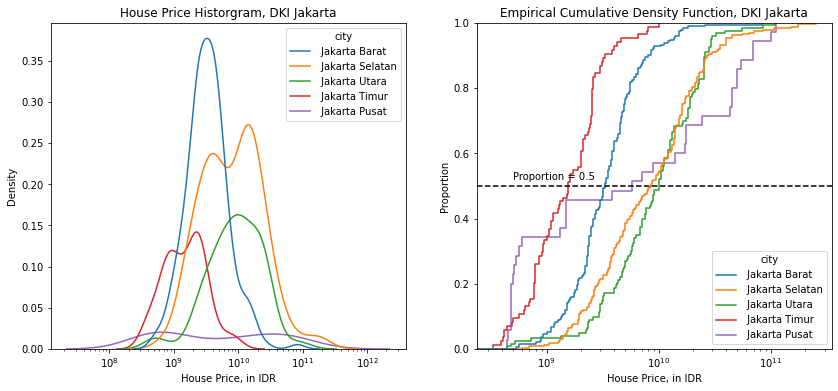

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(
    data=house_df_jakarta, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_jakarta, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram, DKI Jakarta')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5e8, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function, DKI Jakarta')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

We can see the `uniform-like` distribution of the `Jakarta Pusat` house price is somewhat not a commonly-known type of house price distribution. The `Jakarta Pusat` observations is lacking coverage to represent distribution of `Jakarta Pusat House Price Population`.

Thus the limitations of DKI Jakarta observations are concluded as:

1. Lack of coverage for `Jakarta Pusat`, `Jakarta Timur`, and `Jakarta Utara` leads to somewhat inappropriate analysis or justification that involve those city.
2. Further analysis of those city is deemed appropriate if more data can be retrieved, followed by thorough common justification of coverage until deemed representative enough of true population.

However, to maximize the scope of this analysis, we will still consider all of the DKI Jakarta cities other than `Jakarta Pusat` if proven to be statistically significant, since their distributions are somewhat logically acceptable. Note that above limitations will be acknowledged if necessary.

#### **Inference about Jabodetabek Median House Price**

To analyze precision and realibility of our median statistic, we are going to determine interval of estimate in form of `confidence interval`, which explains range of sensible value of population estimate based on our data to infer how close it might be to the true median.

Information about the precision of an interval estimate is conveyed by the width of the interval:
- High confidence level followed by quite narrow interval suggest that dataset gives the reasonable precise knowledge of the parameter
- Wide confidence interval suggest that there is a great deal of uncertainty regarding the estimated value

First let's recall our `price_in_rp` variable statistics as below:

In [44]:
{"tags": ["hide-input"]}

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,median,max
price_in_rp,"3,445.00","4,034,482,148.04","9,872,656,878.52","125,000,000.00","1,500,000,000.00","250,000,000,000.00"


To determine confidence interval of `median` statistics, there are some available `non-parametric methods` that we can use, which known robust enough to estimate the interval estimate of median. In this analysis, we will consider:

1. Maritz-Jarett estimator (will be shorten as `mj`)
2. Hettmansperger-Sheather interpolation (will be shorten as `hs`)
3. Bootstrapping the median from dataset

The `hs` will be based on interpolation of the sorted observations in the dataset so the interval value must be one observation that included in the dataset.

The `bootstrap` confidence interval based on the `bootstrap distribution` if we were to draw repeatedly from the sample, trying to represents what the user knows about the underlying popoulation. The realibility of the `bootstrap` is influenced by how closely the original sample represents the whole distribution.

The `mj` method will use estimated quantile standard error so the value may be not what as included in the dataset.

Let's determine the interval for each of the method above based on `95% confidence level`:

In [45]:
median = np.median(house_df.price_in_rp)
price_data = house_df.price_in_rp.values
median_ci_mj = [
    float(ci) for ci in mquantiles_cimj(
        data=price_data,
        prob=[0.5],
        alpha=0.05)
    ]
median_ci_hs = median_cihs(
        data=price_data,
        alpha=0.05
        )
median_ci_bootstrap = [
    float(ci) for ci in bootstrap(
        data=(price_data, ), method='percentile',
        statistic=np.median, random_state=99).confidence_interval
    ]
median_ci = [
    {'method': method, 'median':median, 'ci_lower': ci[0], 'ci_upper': ci[1]}\
        for method, median, ci in zip(
            ['Maritz-Jarrett', 'Hetmasperger-Sheather', 'Bootstrap CI'],
            [i for i in itertools.repeat(median, 3)],
            [median_ci_mj, median_ci_hs, median_ci_bootstrap]
            )
    ]

pd.DataFrame(median_ci)

,method,median,ci_lower,ci_upper
0,Maritz-Jarrett,"1,500,000,000.00","1,436,204,280.83","1,563,795,719.17"
1,Hetmasperger-Sheather,"1,500,000,000.00","1,450,000,000.00","1,590,000,000.00"
2,Bootstrap CI,"1,500,000,000.00","1,450,000,000.00","1,590,000,000.00"


To generalize above results, we can say that, using our dataset to infer about Jabodetabek House Price:

***"With 95% confidence level, based on provided dataset, the median estimate of Jabodetabek House Price is 1,500,000 rupiahs with margin of error no more than +- 90,000,000 rupiahs"***.

The error is quite low, less than 10% of our estimate.

#### **Testing the Realibility of Interval Estimate**

How can we assure that the method to determine the confidence interval is robust enough for our dataset? We can simulate the `coverage probability` of interval estimate. `Coverage Probability` shows that, if samples is being taken from the population repeatedly, then of all samples, what is the probability of the `confidence interval` determined by those samples contains true statistic of population.

To simulate the `coverage probability`:

1. Take *n samples* repeatedly from a population. Most of the time we don't know the true value of statistics of that population. By forming a `theoretical population`, we then able "know", for example, the median of a population.
2. The coverage probability is then:

$$\frac{number\;of\;occasions\;true\;median\;inside\;interval}{n\;samples}$$

We will approach our population distribution by using `theoretical distribution` that mimics our dataset charateristics. Therefore, `Theoretical Distribution` will estimated from our dataset using `Gaussian KDE` method as follows.

In [46]:
from scipy.stats import gaussian_kde

density = gaussian_kde(price_data)

After we `estimated` the theoretical distribution, we can determine the `true median` of that distribution. We know that median is `50% percentile` of a distribution, we will utilize `scipy optimization program` to calculate its 50% percentile.

I utilize `secant`, which is iterative method of `root_scalar` solver to find the root of a function. Using iterative method, we don't need to know the derivative of the function to solve.

The 50% percentile is *CDF = 50%* of our distribution, so I create a *scalar function* (function that returns a scalar) then find the root of that function.

Given

$$x=random\;variable$$

which in our case, the rvs is `price_in_rp`, then

$$x\;is\;median,\;if\;F(x)=0.5$$


$F(x)$ is CDF function of the theoretical distribution. To find *x* that serve as the median of distribution, we just need to find the root of:

$$F(x) - 0.5 = 0$$

Below codes interpret above concept:


In [47]:
from scipy.optimize import root_scalar

def get_cdf(upper_bound):
    density = gaussian_kde(price_data)
    return (density.integrate_box(-np.inf, upper_bound) - 0.5)

solver = root_scalar(get_cdf, method='secant',  xtol=10e-5, x0=1500000000, x1=1600000000)
print('Median: Rp. {:,.2f}'.format(solver.root))

Median: Rp. 2,145,251,456.29


We don't need to worry about the median of theoretical distribution differs from our original dataset, since the accuracy of estimated distribution is out of our interest. Theoretical distribution is only used for drawing samples repeatedly, serves as a distribution that *mimics* our population characteristics.

Below codes `simulate the sample draws` then calculate the coverage probability, using various number of observations that each sample has (various sample size).

Using below codes, we demonstrate `taking samples repeatedly about 1000 times`. The robust method will gives value near `nominal confidence interval`, which is set to 95% in this analysis.

In [48]:
class CoverageProba():
    def __init__(self, dataset, alpha, n_sample):
        self._dataset = dataset
        self._alpha = alpha
        self._n_sample = n_sample.copy()
        self._density = gaussian_kde(self._dataset)
        self._median = root_scalar(
            self._get_cdf, 
            method='secant',  xtol=10e-5, 
            x0=np.quantile(self._dataset, q=0.25), 
            x1=np.quantile(self._dataset, q=0.75)
            ).root
        self._proba_mj = []
        self._proba_hs = []
        self._proba_bootstrap = []
        
    def _get_cdf(self, upper_bound):
        return (self._density.integrate_box(-np.inf, upper_bound) - 0.5)

    def _median_ci_mj(self, n_sample): # dataset in np.array
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in mquantiles_cimj(
                    data=sample,
                    prob=[0.5],
                    alpha=self._alpha)
                    ]
        return (self._median >= ci_l and self._median <= ci_h)
    
    def _median_ci_hs(self, n_sample):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h =  median_cihs(
                    data=sample,
                    alpha=self._alpha
                    )
        return (self._median >= ci_l and self._median <= ci_h)        
    
    def _median_ci_bootstrap(self, n_sample):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in bootstrap(
                    data=(sample, ), method='percentile',
                    statistic=np.median).confidence_interval
                    ]
        return (self._median >= ci_l and self._median <= ci_h)

    def get_proba(self, n_iterate):
        n_iterate_ = n_iterate
        for i in self._n_sample:
            a = np.empty((n_iterate_, 1))
            ci_mj = np.apply_along_axis(lambda x: self._median_ci_mj(i), 1, a)
            self._proba_mj.append(np.sum(ci_mj) / n_iterate_)
            ci_hs = np.apply_along_axis(lambda x: self._median_ci_hs(i), 1, a)
            self._proba_hs.append((np.sum(ci_hs) / n_iterate_))
            ci_bootstrap = np.apply_along_axis(lambda x: self._median_ci_bootstrap(i), 1, a)
            self._proba_bootstrap.append((np.sum(ci_bootstrap) / n_iterate_))
        return (
            pd.DataFrame(
                {'sample_sizes': self._n_sample,
                'coverage_probability_mj': self._proba_mj,
                'coverage_probability_hs': self._proba_hs,
                'coverage_probability_bootstrap': self._proba_bootstrap
                }
                )
         )
        
coverage = CoverageProba(
    dataset=price_data, 
    alpha=0.05, 
    n_sample=[10, 50, 100, 1000, 2000]
    )
ci_coverage = coverage.get_proba(n_iterate=1000)

ci_coverage

,sample_sizes,coverage_probability_mj,coverage_probability_hs,coverage_probability_bootstrap
0,10,0.97,0.94,0.95
1,50,0.95,0.94,0.94
2,100,0.94,0.95,0.95
3,1000,0.94,0.95,0.95
4,2000,0.95,0.95,0.96


From result above, it seems that `mj` overestimate the confidence interval at lower sample size. Method `hs` and `bootstrap` gives similar results for large sample size.

Let's further inspect each of the values along several sample sizes in figure below:

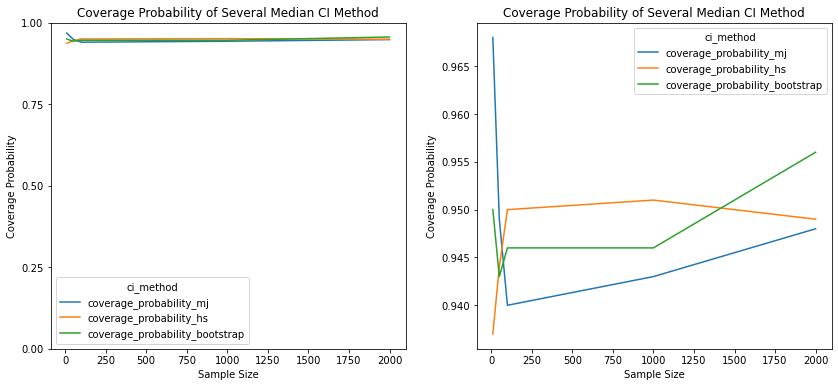

In [49]:
ci_coverage_melt = pd.melt(
    ci_coverage.copy(), id_vars='sample_sizes', 
    value_vars=['coverage_probability_mj', 'coverage_probability_hs', 'coverage_probability_bootstrap'],
    var_name='ci_method', value_name='coverage_probability'
    )
# plot coverage probability
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    sns.lineplot(
        data=ci_coverage_melt, x='sample_sizes', y='coverage_probability', 
        hue='ci_method', ax=ax_)
    ax_.set_xlabel('Sample Size')
    ax_.set_ylabel('Coverage Probability')
    ax_.set_title('Coverage Probability of Several Median CI Method')
ax[0].set_yticks(np.linspace(0, 1, 5))

We will use `hs` to determine interval estimate of median price, since `bootstrap` involves more computation.

For Jabodetabek house price:

In [50]:
def median_ci_hs(array, alpha=0.05, output='upper'):
    ci_l, ci_h = median_cihs(
            data=array,
            alpha=alpha
            )
    if output =='lower':
        return ci_l
    return ci_h

def get_ci_df(df):
    df_ = df.copy()
    return (df_[['city', 'price_in_rp']]\
        .groupby('city')\
        .aggregate(
            median=pd.NamedAgg(column='price_in_rp', aggfunc=np.median),
            ci_lower = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x, output='lower')),
            ci_upper = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x)))\
        .reset_index()\
        .sort_values('median')
        )

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'  
median_ci_jabodetabek = get_ci_df(house_df_simple)

median_ci_jabodetabek

,city,median,ci_lower,ci_upper
0,Bekasi,"975,000,000.00","920,000,000.00","1,050,000,000.00"
3,Depok,"995,000,000.00","945,000,000.00","1,070,686,822.87"
1,Bogor,"1,200,000,000.00","1,090,403,259.36","1,350,000,000.00"
4,Tangerang,"2,395,000,000.00","2,154,472,505.05","2,600,000,000.00"
2,DKI Jakarta,"4,500,000,000.00","4,000,000,000.00","4,950,000,000.00"


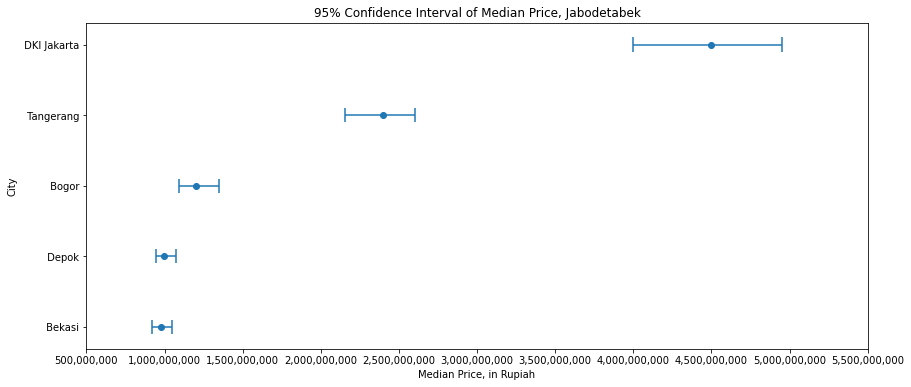

In [51]:
def plot_ci(df, title):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.hlines(y=df.city, xmin=df.ci_lower, xmax=df.ci_upper)
    y_ticks = np.array(ax.get_yticks())
    x_ticks = ax.get_xticks()
    x_ticks = x_ticks.copy()[x_ticks.copy() >= 0]
    ax.vlines(x=df.ci_lower, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.vlines(x=df.ci_upper, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.scatter(x=df['median'], y=df.city)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax.set_title(f'95% Confidence Interval of Median Price, {title}')
    ax.set_xlabel('Median Price, in Rupiah')
    ax.set_ylabel('City')

plot_ci(median_ci_jabodetabek, 'Jabodetabek')

`DKI Jakarta` has larger interval range above any other city. We have slightly higher confidence in our analysis for `Bogor`, `Depok`, `Bekasi` since they have narrow interval range.

Now let's inspect DKI Jakarta interval estimate:

In [52]:
{"tags": ["hide-input"]}

median_ci_jakarta = get_ci_df(house_df_jakarta)
median_ci_jakarta

,city,median,ci_lower,ci_upper
3,Jakarta Timur,"1,550,000,000.00","1,123,907,782.14","2,036,207,490.18"
0,Jakarta Barat,"3,300,000,000.00","2,871,827,173.85","3,728,172,826.15"
1,Jakarta Pusat,"5,800,000,000.00","812,627,444.89","17,500,000,000.00"
2,Jakarta Selatan,"8,500,000,000.00","6,250,000,000.00","10,687,341,965.65"
4,Jakarta Utara,"10,000,000,000.00","7,535,086,312.49","11,824,568,437.56"


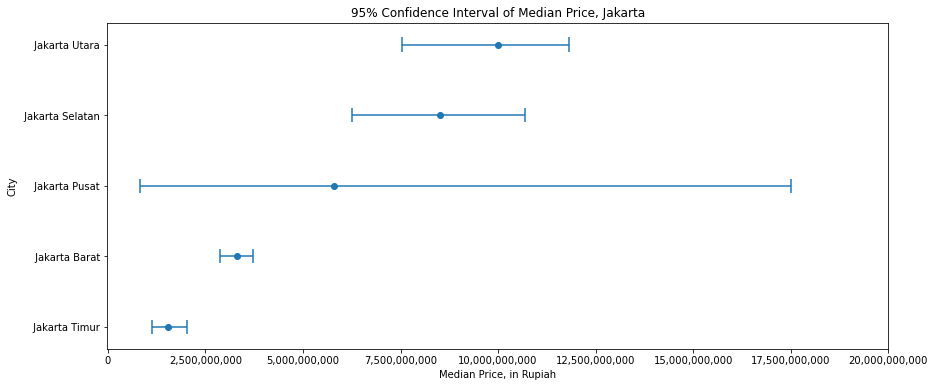

In [53]:
{"tags": ["hide-input"]}

plot_ci(median_ci_jakarta, 'Jakarta')

As we can see, there is a lot of uncertainty regarding house price of `Jakarta pusat`, further reinforcing our previous knowledge about lack of coverage for `Jakarta Pusat` from our dataset. 

## 3.2. House Price according to Certificate Type

In this section, we will analyze house price according to its `certificate` type. We will investigate if homeowner believe that specific certificate type increases their house value.

First, we will look at the distribution of price according to specific house certificates.

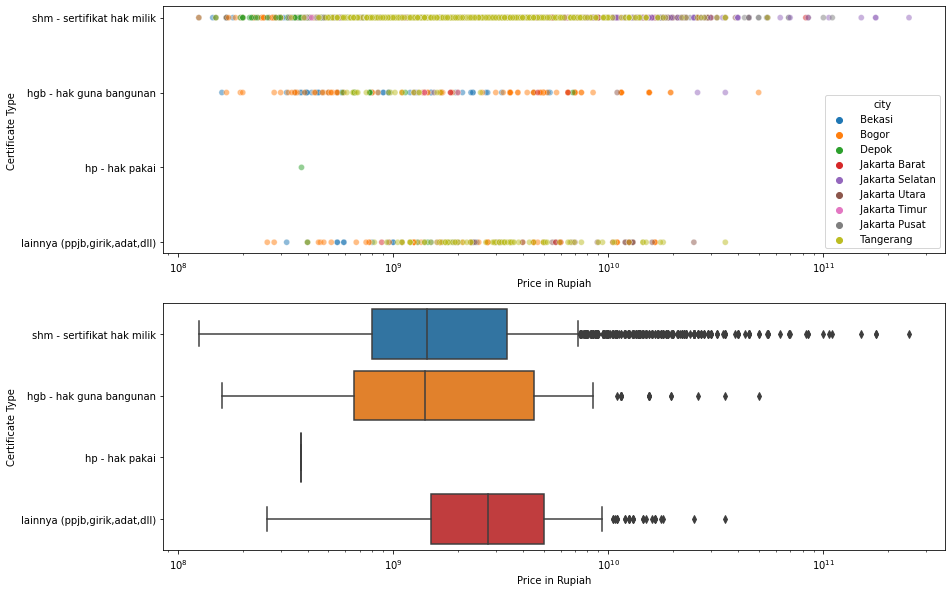

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
sns.scatterplot(data=house_df, y='certificate', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')
    ax_.set_xscale('log')

Y-axis ticks on above figure is sorted according to our common believe on how valuable each certificate is: `shm - sertifikat hak milik` legal-wise is generally the most valuable among the others, down to `ppjb, girik, adat, dll`.

We will develop statistical test based on confidence interval of `median difference` statistic, multiple tested between each of the certificate type for each city. This time we will utilize bootstrapping method using `scipy.bootstrap`. Minimum `sample size` is set to `50`, hence `hp - hak pakai` will not be tested.

Let's take an example of multiple testing for house located in `Bogor`.

In [55]:
def median_diff(sample_1, sample_2):
    statistic = np.median(sample_1) - np.median(sample_2)
    return statistic

sample_size = 50
city = ' Bogor'
categories = ['shm - sertifikat hak milik', 'hgb - hak guna bangunan', 'lainnya (ppjb,girik,adat,dll)']
sample_1 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'shm - sertifikat hak milik')]\
        .price_in_rp.sample(sample_size).values
sample_2 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'hgb - hak guna bangunan')]\
        .price_in_rp.sample(sample_size).values
data = (sample_1, sample_2)
res = bootstrap(data, median_diff, method='basic', vectorized=False)

res.confidence_interval

ConfidenceInterval(low=-4646000000.0, high=-1038000000.0)

Based on interval above:

- the statistics is `median(sample_1) - median(sample_2)`, `sample_1 = shm - sertifikat hak milik`, `sample_2 = hgb - hak guna bangunan`
- The interval is located in `negative area`, means that for `Bogor` most of house with `shm` certificate is associated with lower house price than house with `hgb` certificate. However we simply can't conclude that `shm` drove the house price lower.
- Recall that confidence interval contains the sensible value of estimate. Therefore, interval that includes `0` values means there is evidence of **no median difference between tested samples**. In above example, it concluded that there was a median difference between `shm` and `hgb`.
- It is worth noting the practical significance of the calculated statistics. For example, median difference of $10,000,000$ may reject the null hypotheses but was insignificance for typical house price.  

Above findings can also be inspected using box-plot below:

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
sns.scatterplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')

Using codes below, we will look if there exist some patterns that follows our believe of `certificate` order: 

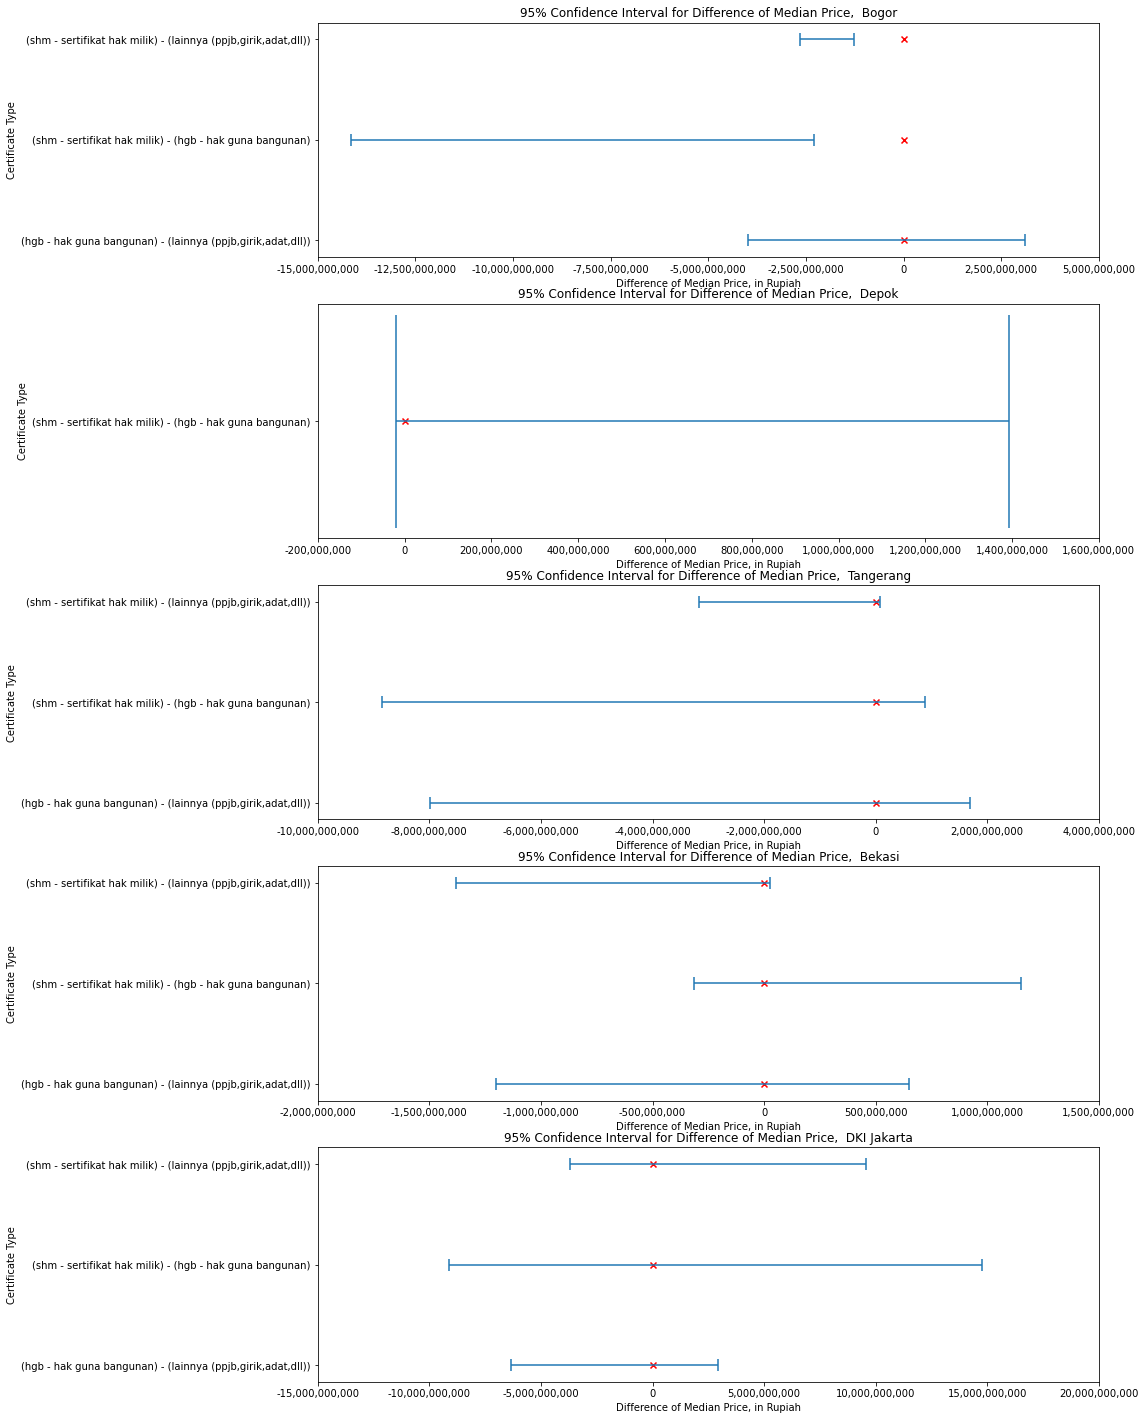

In [56]:
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df_simple[column] = \
        pd.Categorical(
            values=house_df_simple[column],
            categories=order,
            ordered=True
            )
cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
categories = list(house_df_simple.certificate.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
records = []
sample_size = 10
for city in cities:
    df = house_df_simple[house_df_simple.city == city]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.certificate == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
                df.certificate == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })
median_df_test = pd.DataFrame(records)
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 6))
for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city].sort_values('category_1')
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Certificate Type')

The interval is somewhat arbitrary, no distinguishable pattern can be identified. If our believe was true, the interval would move from top-right to bottom-left.

There is also, in 95% confidence level, presents evidence of `no median difference` (interval includes `0` values, marked with red `x`).

In summary, statistically, higher house price is not associated with specific `certificate` type. The linear model in the next chapter may prove this evidence, which we will acknowledge later.

## 3.3. House Price according to Property Condition

Similar with previous section, we will investigate if homeowner believe that specific property condition (whether the house is new or needs some renovation) increases their house value.

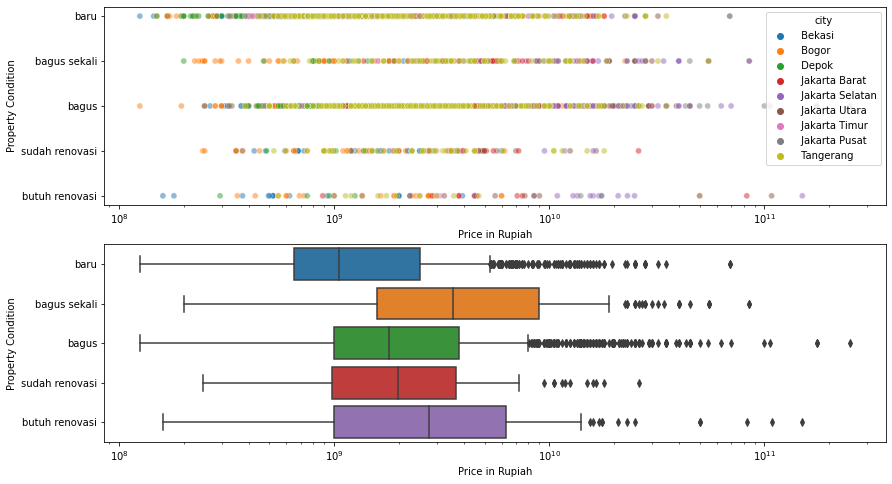

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
sns.scatterplot(data=house_df, y='property_condition', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='property_condition', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Property Condition')
    ax_.set_xscale('log')

In [59]:
{"tags": ["hide-input"]}

cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
analyze_condition = ['baru', 'bagus sekali', 'bagus', 'sudah renovasi', 'butuh renovasi']
records = []
sample_size = 30
categories = list(house_df_simple.property_condition.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
for city in cities:
    df = house_df_simple[
        (house_df_simple.city == city) & (house_df.property_condition.isin(analyze_condition))]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.property_condition == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
               df.property_condition == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })
median_df_test = pd.DataFrame(records)
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 5))
for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city]
    df = df.iloc[::-1]
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Property Condition')

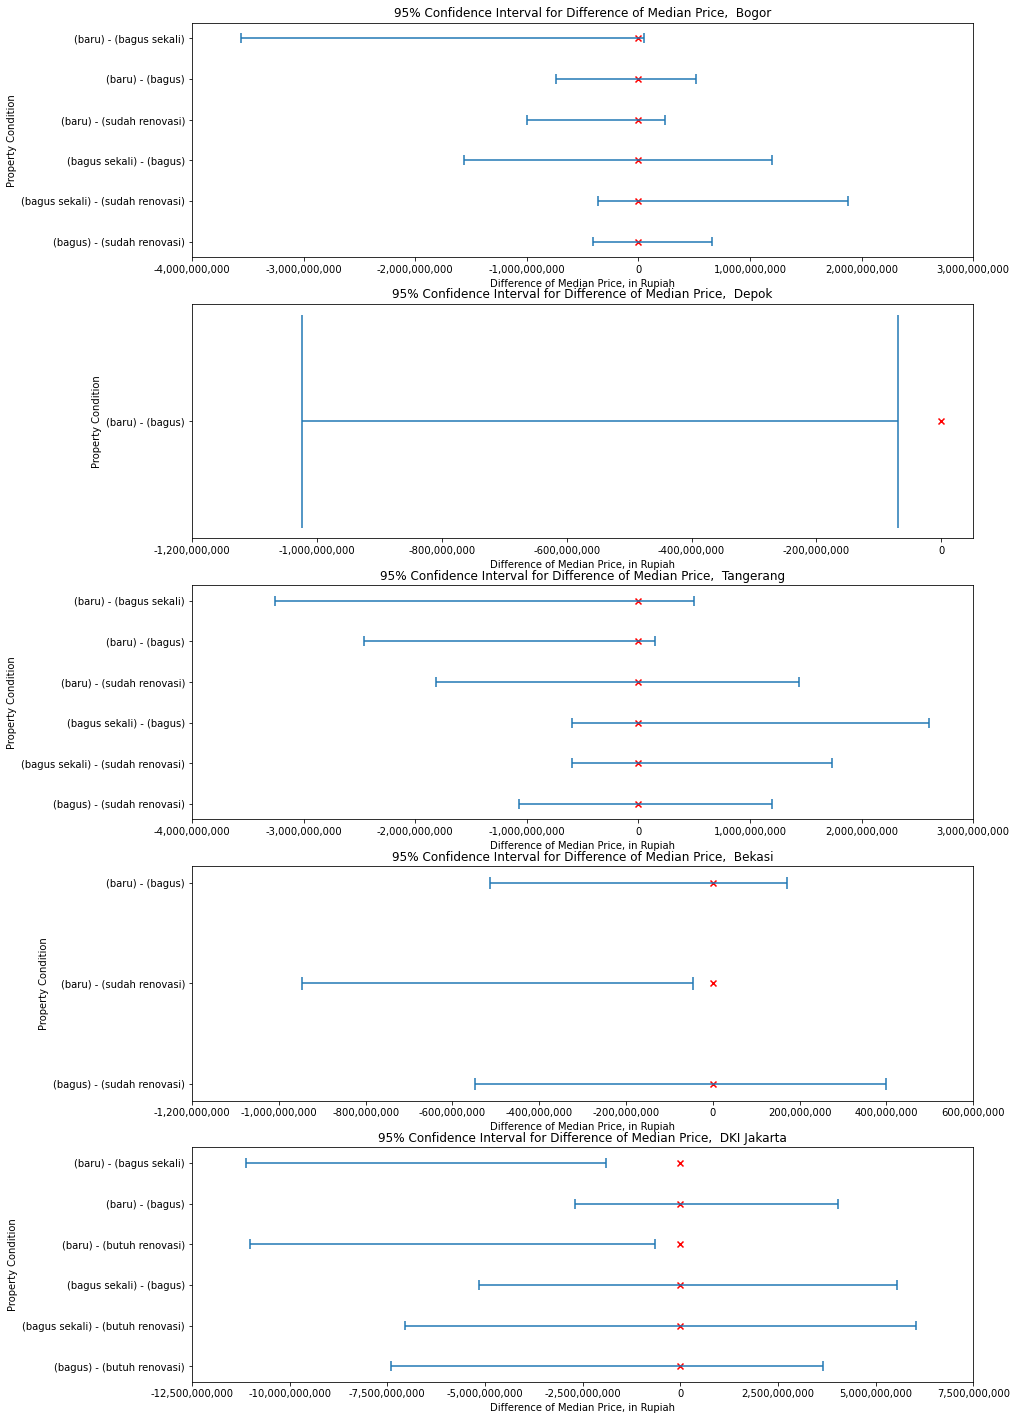

Again, no distinguishable pattern can be identified. Statistical evidence of `no median difference` mostly present for each city in Jabodetabek.

Statistically, higher house price is not associated with specific `property condition`.

## 3.5. House Price according to Electricity

In this section, we will investigate how `electricity` associated with house price. We also want to identify the price distribution of observations with missing `electricity` records, filled as `lainnya - mah`.

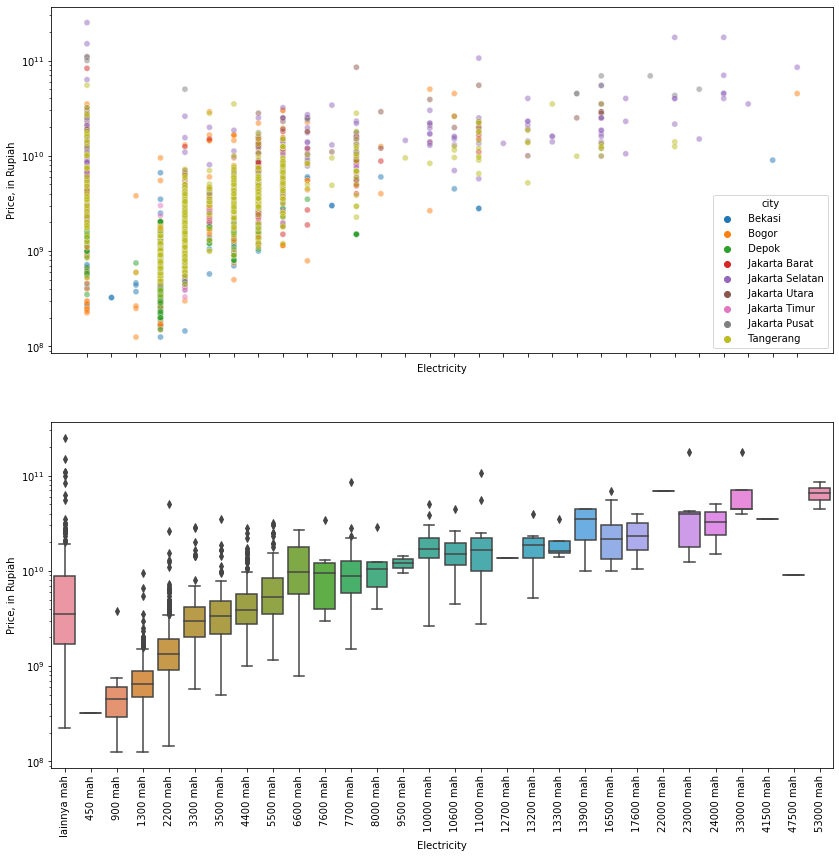

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
sns.scatterplot(data=house_df, y='price_in_rp', x='electricity', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='price_in_rp', x='electricity', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_yticks()
    yticks = ticks[ticks >= 0]
    ax_.set_xticks(ax_.get_xticks())
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=90)
    ax_.set_yticks(yticks)
    ax_.set_yticklabels(['{:,.0f}'.format(ytick) for ytick in yticks])
    ax_.set_xlabel('Electricity')
    ax_.set_ylabel('Price, in Rupiah')
    ax_.set_yscale('log')

The missing `electricity` records cover almost entire house price range. Note that larger `electricity` is associated with larger house price. It is somewhat understandable because large house tends to have higher `electricity` setting. This reason can be proven if `electricity` has a high correlation coefficient with `building_size_m2`.

## 3.5. House Price according to Numerical Features

In this section, we will identify whether `price_in_rp` has some recognizable pattern in particular numerical feature.

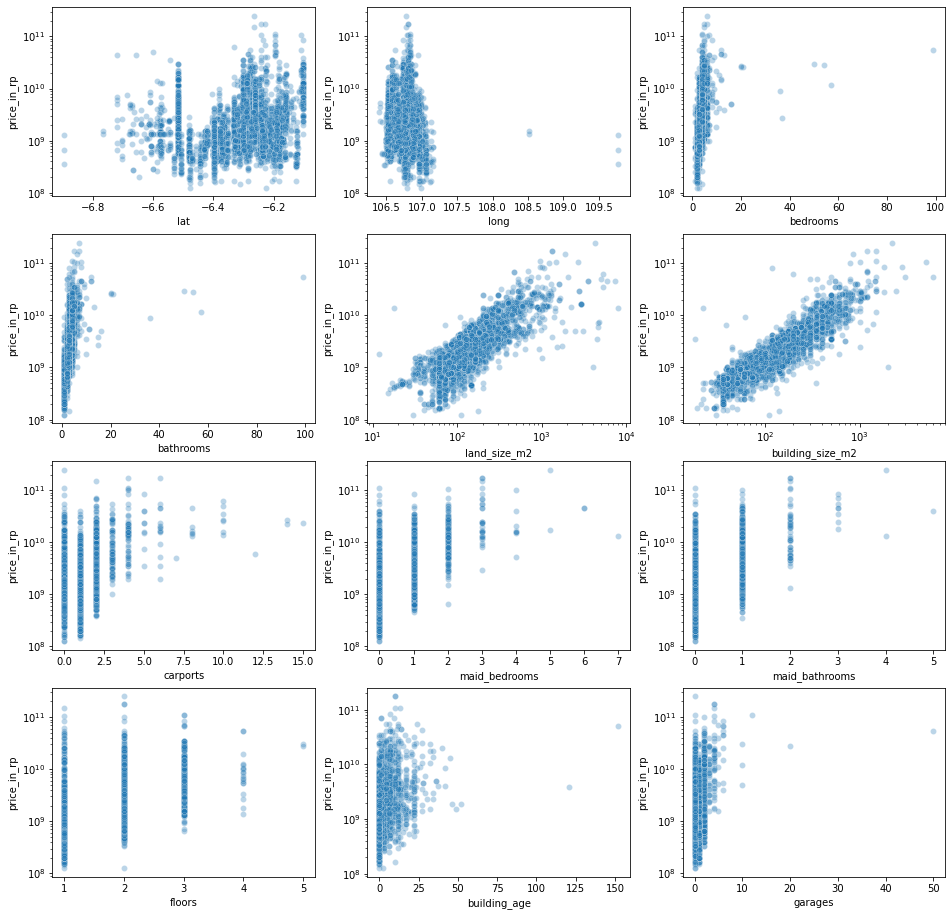

In [62]:
numerical_features = house_df\
    .select_dtypes(exclude=['object', 'category'])\
        .drop(['price_in_rp', 'year_built'], axis=1).columns

fig, ax = plt.subplots(4, 3, figsize=(16, 16))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), numerical_features):
    sns.scatterplot(data=house_df, x=feature, y='price_in_rp', alpha=0.3, ax=ax[ax_index])
    if (house_df[feature].dtypes == 'float') & (feature not in ['lat', 'long', 'electricity_num']):
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

Linear pattern is identified in `building size` and `land size` features. For variable (e.g. `floors`, `carports`), which larger value associated with larger building size, also shows increasing pattern of house price.

Heatmap of correlation coefficient is shown below. The coefficient is calculated using `Spearman` method. Clustering alogrithm is applied for the chart. It orders the features which has similar correlation located closely, resulting in tidier presentation hence easier to analyze.  

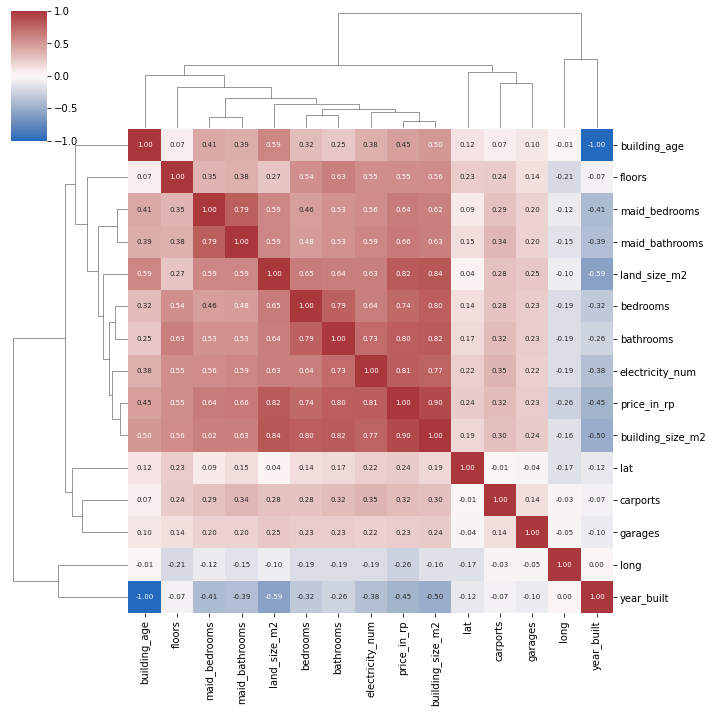

In [64]:
columns_corr = house_df.columns[~house_df.columns.isin(list(fac_columns))]
house_df_corr = house_df[columns_corr].corr(method='spearman')
sns.clustermap(house_df_corr, vmin=-1, vmax=1, center=0, cmap='vlag', annot=True, fmt='.2f', annot_kws={'size': 7})

From above heatmap, we can recognize feature that has a high correlation coefficient with `building_size_m2` also has a high correlation with `price_in_rp`. Those features possibly influence the house price, which will be analyzed in the next chapter.

# 4. Preparing Dataset for Modeling

### 4.1. Subsetting the Test Set for Assessing Prediction

Test set will be useful to assess how well our linear model generalize to the unknown observations independent of our dataset.

In [65]:
from sklearn.model_selection import train_test_split

X = house_df.drop('price_in_rp', axis=1)
y = house_df.price_in_rp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99
    )

### 4.2. Missing Values

First let's review missing data from our original dataset (yes, not `train` or `test set`). By evaluating `original dataset`, we analyze the possibility of missing value for both scenarios.

In [66]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,32,0.93,Int64
bathrooms,28,0.81,Int64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,Int64
maid_bedrooms,0,0.00,Int64
maid_bathrooms,0,0.00,Int64


For non-numeric features:

In [67]:
non_numeric_features = house_df.select_dtypes(include=['object']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
ads_id,4,0.12,object


Remember that those observations (from our original dataset) with missing records may exist in `training set`, `test set` or may be in both. Therefore, we must develop method to handle missing value that works for `training set`, `test set`, and even `potential future data` which we want to predict if any. Possible method:

1. Drop observations that have missing `bathrooms` or `bedrooms`, `land_size` and `building_size` records
2. Drop `building_age`, `year_built`, and `building_orientation` which have a lot of missing value
3. For missing `floors` and `electricity_num`, will be imputed. Features that used for imputation is best choosen according to its correlation coefficient (previous chapter).
4. For missing `certificate`, let's assume `certificate = lainnya`.
5. For missing `property_condition` and `furnishing`, let's assume majority of data.

According to above explanation, it should be noted that if there are any `future data` that we want to predict, the only missing features that can be considered are `floors`, `electricity`, `certificate`, `property_condition` and `furnishing`. Other than that, the prediction can't be performed.

In below codes, note that the imputation is fitted only with `train set` to ensure that the prediction model is isolated from `test set` (avoding data leakage)

In [68]:
from sklearn.impute import SimpleImputer, KNNImputer

# 1. Drop observations that missing vital records
X_train = X_train\
    .dropna(subset=['bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2'])
y_train = y_train[X_train.index] # remember to also drop the particular index of label data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# 2. Drop features with lot of NaN    
X_train = X_train\
    .drop(['building_age', 'year_built', 'building_orientation'], axis=1)
# 3.a. Impute missing `floors`
knn_imputer = KNNImputer(n_neighbors=1)
missing_floors_index = X_train[X_train.floors.isna()].index
features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']
imputer_floors = knn_imputer.fit(X_train[features_estimator_floors])
imputed_data_floors = imputer_floors.transform(X_train[features_estimator_floors])
X_train = X_train.assign(
    floors = imputed_data_floors[:, 3]
    )
# 3.b. Impute missing `Electricity`
features_estimator_electricity = [
    'building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num'
    ]
missing_electricity_index = X_train[X_train.electricity_num.isna()].index
imputer_electricity = knn_imputer.fit(X_train[features_estimator_electricity])
imputed_data_electricity = imputer_electricity.transform(X_train[features_estimator_electricity])
X_train = X_train.assign(
    electricity_num = imputed_data_electricity[:, 4]
    )
# 4. Impute missing `certificate`
constant_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
X_train['certificate'] = constant_imputer.fit_transform(X_train[['certificate']]).flatten()
# 5. Impute missing `property_condition` and `furnishing`
frequent_imputer = SimpleImputer(strategy='most_frequent')
X_train['property_condition'] = frequent_imputer\
    .fit_transform(X_train[['property_condition']])\
    .flatten()
X_train['furnishing'] = frequent_imputer\
    .fit_transform(X_train[['furnishing']])\
    .flatten()

Let's see the imputation result:

In [69]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors']
pd.merge(
    X_train.iloc[missing_floors_index, X_train.columns.get_indexer(show_features)],
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1265,200.00,187.00,3,3,2.00,"2,750,000,000.00"
1465,600.00,250.00,3,3,3.00,"13,000,000,000.00"
1703,250.00,320.00,4,4,2.00,"8,300,000,000.00"
2425,358.00,200.00,4,4,3.00,"10,100,000,000.00"


In [70]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']
pd.merge(
    X_train\
    .iloc[missing_electricity_index, X_train.columns.get_indexer(show_features)]\
    .head(),
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,336.00,136.00,10,11,4.00,"3,500.00","5,500,000,000.00"
6,240.00,136.00,4,4,3.00,"2,200.00","6,000,000,000.00"
7,839.00,785.00,6,5,3.00,"16,500.00","26,000,000,000.00"
32,252.00,250.00,5,4,2.00,"3,300.00","2,790,000,000.00"
35,91.00,120.00,3,2,2.00,"2,200.00","2,130,000,000.00"


### 4.3. Unnecessary Features and Features with High Cardinality

Features with high cardinality won't be useful for prediction hence will be dropped.

In [71]:
cols_to_drop = ['url', 'title', 'address', 'district', 'ads_id', 'facilities', 'property_type', 'electricity']
X_train.drop(cols_to_drop, axis=1, inplace=True)

### 4.4. Conclusion: Prepared Features

Our prepared fueatures should be as below:

In [72]:
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,Int64
bathrooms,0,0.00,Int64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,0,0.00,Int64
maid_bedrooms,0,0.00,Int64
maid_bathrooms,0,0.00,Int64
floors,0,0.00,float64


In [73]:
{"tags": ["hide-input"]}

non_numeric_features = X_train.select_dtypes(include=['object']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
city,0,0.00,object
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object


### 4.5. Additional: Pipeline for Test Set

Scikit-learn provides `pipeline` program to create reusable transformer that contains sequential treatment/steps which to be applied to the dataset that passed into that `pipeline`.

#### **Transformer to drop Observations with Missing Records**

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class RowsDropper(BaseEstimator, TransformerMixin):
    """ 
    Remove observations that missing any records from features that
    specified in `mandatory_features` 
    """
    def __init__(self, mandatory_features):
        self.mandatory_features = mandatory_features.copy()
        self.dropped_index = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.dropped_index = X[X[self.mandatory_features].isna()].index
        X_new = X.dropna(subset=self.mandatory_features)
        X_new.reset_index(drop=True, inplace=True)
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Features-Dropper Transformer**

In [75]:
class FeaturesDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list):
        self.drop_list = drop_list.copy()
        self.cols_dropped = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # checking if streamed data has unused features
        self.cols_dropped +=\
            [column for column in X.columns if column in self.drop_list]
        if self.cols_dropped:
            X_new = X.drop(self.cols_dropped, axis=1)
            return X_new
        else:
            return X
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Transformer for Specific Columns**

In [76]:
class FloorsKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_floors])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_floors = self._knn_imputer.transform(X_transf[self._features_estimator_floors])
        X_new = X_transf.assign(
            floors = imputed_data_floors[:, 3]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

class ElectricityKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_electricity = \
            ['building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_electricity])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_electricity = self._knn_imputer.transform(X_transf[self._features_estimator_electricity])
        X_new = X_transf.assign(
            electricity_num = imputed_data_electricity[:, 4]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Creating Pipeline for Train-Test Set**

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config

mandatory_features = ['price_in_rp', 'bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2']
columns_to_drop = [
            'building_age', 'year_built', 'building_orientation',
            'url', 'title', 'address', 'district', 'ads_id', 'facilities', 
            'property_type', 'electricity'
            ]
rows_dropper = RowsDropper(mandatory_features)
features_dropper = FeaturesDropper(columns_to_drop)
floors_imputer = FloorsKNNImputer()
electricity_imputer = ElectricityKNNImputer()
certificate_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
features_transf = ColumnTransformer([
    ('certificate_impute', certificate_imputer, ['certificate']),
    ('property_condition_impute', SimpleImputer(strategy='most_frequent'), ['property_condition']),
    ('furnishing_impute', SimpleImputer(strategy='most_frequent'), ['furnishing'])
    ], remainder='passthrough')
dataset_transform_pipeline = make_pipeline(
    rows_dropper,
    features_dropper,
    floors_imputer,
    electricity_imputer,
    features_transf
    )

set_config(display='diagram')
dataset_transform_pipeline

Pipeline(steps=[('rowsdropper',
                 RowsDropper(mandatory_features=['price_in_rp', 'bedrooms',
                                                 'bathrooms',
                                                 'building_size_m2',
                                                 'land_size_m2'])),
                ('featuresdropper',
                 FeaturesDropper(drop_list=['building_age', 'year_built',
                                            'building_orientation', 'url',
                                            'title', 'address', 'district',
                                            'ads_id', 'facilities',
                                            'property_type', 'electricity'])),
                ('floorsknnimputer', Floors...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('certificate_impute',
                                                  SimpleImputer(fill_value='lainnya '
                                                                           '(ppjb,girik,adat,dll)',
                                                                strategy='constant'),
                                                  ['certificate']),
                                                 ('property_condition_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['property_condition']),
                                                 ('furnishing_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['furnishing'])]))])

#### **Demonstrating Pipeline for Train Set**

In [78]:
df_train, df_test =  train_test_split(house_df, test_size=0.1, random_state=99)

In [79]:
transfd_columns = ['certificate', 'property_condition', 'furnishing']
dataset_columns = \
    transfd_columns + [column for column in house_df.drop(columns_to_drop, axis=1) if column not in transfd_columns]

train_set_transfd = pd.DataFrame(
    dataset_transform_pipeline.fit_transform(df_train), 
    columns=dataset_columns)
for column in train_set_transfd.columns:
    train_set_transfd[column] = pd.to_numeric(train_set_transfd[column], errors='ignore')
    
DataExploration(train_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,int64
bathrooms,0,0.00,int64
land_size_m2,0,0.00,float64


In [80]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'price_in_rp']
train_set_transfd .iloc[missing_floors_index, train_set_transfd .columns.get_indexer(show_features)]

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1265,200.00,187.00,3,3,2.00,"2,750,000,000.00"
1465,600.00,250.00,3,3,3.00,"13,000,000,000.00"
1703,250.00,320.00,4,4,2.00,"8,300,000,000.00"
2425,358.00,200.00,4,4,3.00,"10,100,000,000.00"


In [81]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num', 'price_in_rp']
train_set_transfd \
    .iloc[missing_electricity_index, train_set_transfd.columns.get_indexer(show_features)]\
    .head()

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,336.00,136.00,10,11,4.00,"3,500.00","5,500,000,000.00"
6,240.00,136.00,4,4,3.00,"2,200.00","6,000,000,000.00"
7,839.00,785.00,6,5,3.00,"16,500.00","26,000,000,000.00"
32,252.00,250.00,5,4,2.00,"3,300.00","2,790,000,000.00"
35,91.00,120.00,3,2,2.00,"2,200.00","2,130,000,000.00"


The advantage of using pipeline is to assure that necessary dataset transformation can also be applied for the data independent of `train-test set`. As an example, here we will transform the *suspicious* house data records that has been isolated for analysis purposes.

In [82]:
suspicious_records = pd.read_csv('Dataset/suspicious_records.csv')
sus_set = pd.DataFrame(
    dataset_transform_pipeline.transform(suspicious_records), 
    columns=dataset_columns)

for column in sus_set.columns:
    sus_set[column] = pd.to_numeric(sus_set[column], errors='ignore')

Let's inspect transformed data:

In [83]:
DataExploration(sus_set).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,int64
bathrooms,0,0.00,int64
land_size_m2,0,0.00,float64


#### **Demonstrating Pipeline for Test Set**

In [84]:
test_set_transfd = pd.DataFrame(dataset_transform_pipeline.transform(df_test), columns=dataset_columns)
for column in test_set_transfd.columns:
    test_set_transfd[column] = pd.to_numeric(test_set_transfd[column], errors='ignore')

# show missing values summary   
DataExploration(test_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,int64
bathrooms,0,0.00,int64
land_size_m2,0,0.00,float64


#### **Exporting Pipeline for Future Use**

Fitted estimator can be persisted for future use. In this example, we will use scikit-learn `joblib`:

In [85]:
from joblib import dump

dump(dataset_transform_pipeline, 'Output\dataset_transform_pipeline.joblib')

['Output\\dataset_transform_pipeline.joblib']

#### **Exporting Train-Test Set for other Models**

In [86]:
# Full dataset
house_df.to_csv('Dataset\jabodetabek_house_data_prcsd.csv', index=False)
# Train set
X_train = train_set_transfd.drop('price_in_rp', axis=1)
y_train = train_set_transfd[['price_in_rp']]
# Test set
X_test = test_set_transfd.drop('price_in_rp', axis=1)
y_test = test_set_transfd[['price_in_rp']]
# Export to csv
X_train.to_csv('Dataset/X_train.csv', index=False)
y_train.to_csv('Dataset/y_train.csv', index=False)
X_test.to_csv('Dataset/X_test.csv', index=False)
y_test.to_csv('Dataset/y_test.csv', index=False)

# 5. Closing

We already analyzed the dataset features and characteristic alongside handle ambiguous records. Features that are believed to be important aspects of house price already studied. 

Typical house price is best to be presentad as median, with estimate of 1,500,000 rupiahs and margin of error no more than +- 90,000,000 rupiahs. It is found that there is not enough observations to estimate house price and make precise inference for `Jakarta Utara`.

It can be found that, based on provided data, there is no significant evidence that **Jabodetabek House Price** is influenced by **building condition**, **furnishing condition**, or **certificate type**. This analysis has been done by testing median difference for each available conditions and interpreting the confidence interval. 